In [293]:
# Standard Libraries
import os
import warnings
import shutil
from itertools import cycle

# Data Manipulation
import numpy as np
import pandas as pd

# Image Processing
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Plotting and Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

# Machine Learning Tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Logging and Warnings
from absl import logging
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow')


In [294]:
# Path to the main directory
main_dir = 'vehicles'

# Get the list of subfolders within the 'vehicles' folder
sf_categories = [folder for folder in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, folder))]

In [295]:
# Print the subfolders
print("Subfolders:")
for folder in sf_categories:
    print(folder)

Subfolders:
Auto Rickshaws
Bikes
Cars
Motorcycles
Planes
Ships
Trains


In [296]:
categories = ["Auto Rickshaws", "Bikes", "Cars", "Motorcycles", "Planes", "Ships", "Trains"]

In [297]:
# Path to the main directory
main_dir = 'vehicles'

In [298]:
# Get the list of subfolders within the 'vehicles' folder
categories = [folder for folder in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, folder))]
print("Categories:", categories)

Categories: ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']


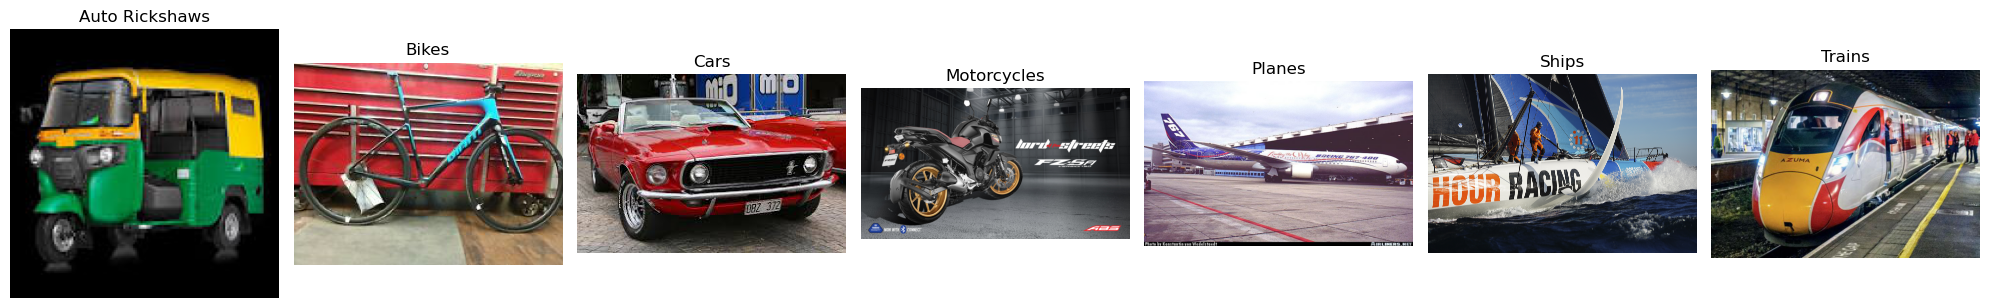

In [299]:
# Plot example images from each category
fig, axes = plt.subplots(1, len(sf_categories), figsize=(20, 5))

for ax, category in zip(axes, sf_categories):
    category_path = os.path.join(main_dir, category)
    image_files = os.listdir(category_path)
    
    if image_files:
        image_path = os.path.join(category_path, image_files[0])
        img = Image.open(image_path)
        ax.imshow(img)
        ax.set_title(category)
        ax.axis('off')
    else:
        ax.set_title(category)
        ax.axis('off')

plt.tight_layout()
plt.show()

In [300]:
# Define a custom transformer for loading images
class ImageLoader(BaseEstimator, TransformerMixin):
    def __init__(self, image_size=(150, 150)):
        self.image_size = image_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        images = []
        for filepath in X:
            img = load_img(filepath, target_size=self.image_size)
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            images.append(img_array)
        return np.array(images)

In [301]:
# Define a custom transformer for labeling images
class LabelExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        labels = [os.path.basename(os.path.dirname(filepath)) for filepath in X]
        return np.array(labels)

In [302]:
# Get all image file paths from the dataset directory
def get_image_file_paths(dataset_path):
    file_paths = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                file_paths.append(os.path.join(root, file))
    return file_paths

In [303]:
# Dataset directory
dataset_path = 'vehicles'

# Get file paths
file_paths = get_image_file_paths(dataset_path)

In [304]:
# Create the pipeline
pipeline = Pipeline([
    ('image_loader', ImageLoader(image_size=(150, 150))),  
    ('label_extractor', LabelExtractor())
])

In [305]:
# Apply the pipeline to the file paths
X = file_paths
X_preprocessed = pipeline.named_steps['image_loader'].transform(X)
y = pipeline.named_steps['label_extractor'].transform(X)

c:\Users\Suvashin\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [306]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Number of classes:", len(le.classes_))

Number of classes: 7


In [307]:
X_train, X_test, Y_train, Y_test = train_test_split(X_preprocessed, y_encoded, test_size=0.2, random_state=123)

In [308]:
images = np.array(X_train)
labels = np.array(y_encoded)

In [309]:
# Print the shapes of the arrays
print("Shape of images:", images.shape)
print("Label size:", labels.shape)

Shape of images: (4403, 150, 150, 3)
Label size: (5504,)


In [310]:
### Model Building

model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(le.classes_), activation='softmax')
])

In [311]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 73, 73, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,637,255 (40.58 MB)

 Trainable params: 10,637,255 (40.58 MB)

 Non-trainable params: 0 (0.00 B)

In [312]:
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [313]:
# Train the model
history = model.fit(X_train, Y_train, epochs=7, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/7
138/138 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.3266 - loss: 2.3846 - val_accuracy: 0.7439 - val_loss: 0.8095
Epoch 2/7
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.7532 - loss: 0.7248 - val_accuracy: 0.7693 - val_loss: 0.6598
Epoch 3/7
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.8470 - loss: 0.4383 - val_accuracy: 0.8283 - val_loss: 0.5443
Epoch 4/7
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9235 - loss: 0.2454 - val_accuracy: 0.8320 - val_loss: 0.5420
Epoch 5/7
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9673 - loss: 0.1143 - val_accuracy: 0.8383 - val_loss: 0.6010
Epoch 6/7
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9810 - loss: 0.0737 - val_accuracy: 0.8338 - val_loss: 0.6260
Epoch 7/7
138/138 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.9795 - loss: 0.0647 - val_accuracy: 0.8283 - val_loss: 0.6857


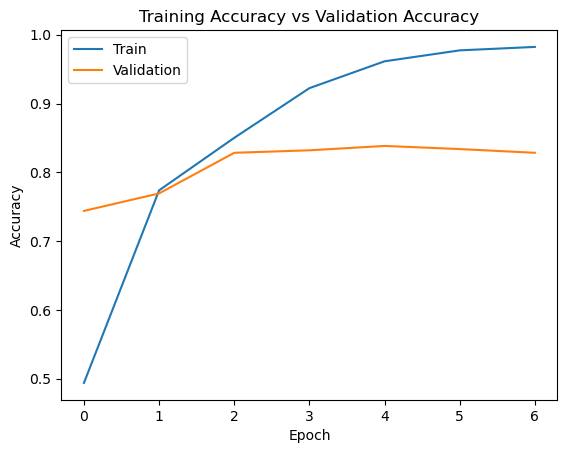

In [314]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

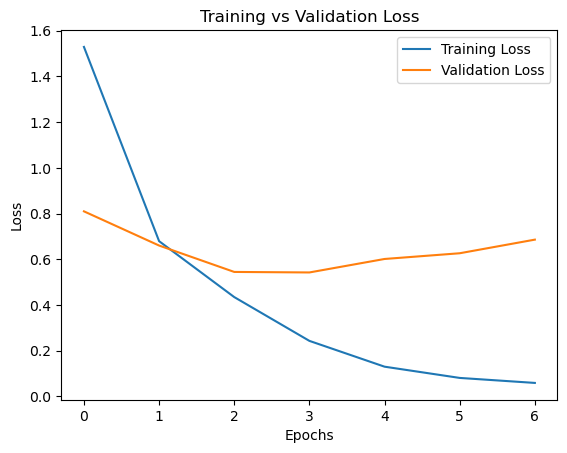

In [315]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [316]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


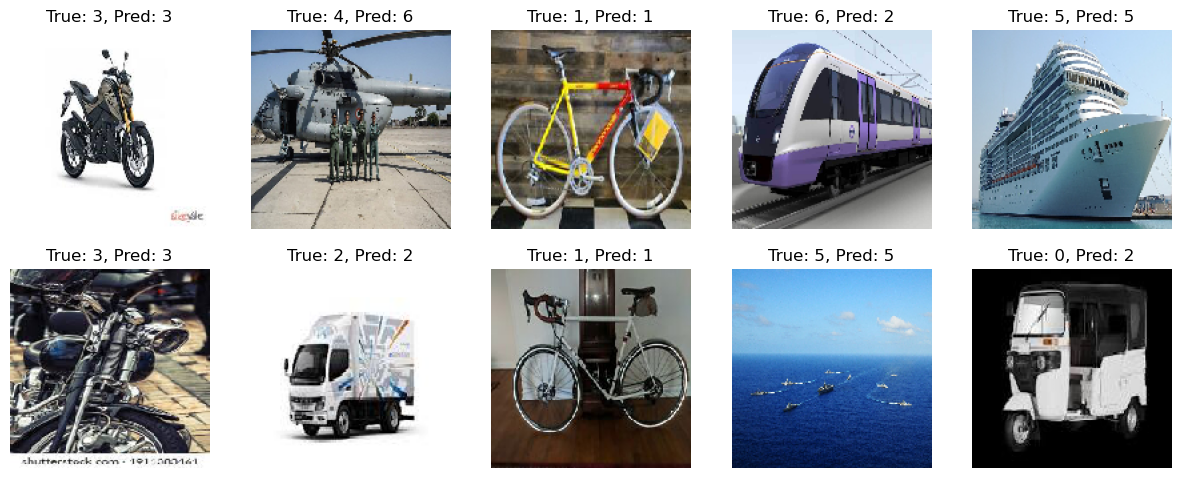

In [317]:
def plot_predictions(X, y_true, y_pred, num_samples=10):
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        plt.subplot(5, 5, i + 1)
        plt.imshow(X[i])
        plt.title(f"True: {y_true[i]}, Pred: {y_pred[i]}")
        plt.axis('off')
    plt.show()


plot_predictions(X_test, Y_test, predicted_classes, num_samples=10)

In [318]:
accuracy = accuracy_score(Y_test, predicted_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 82.83%


In [319]:
# Save the model
model.save('vehicle_classifier.h5')

In [320]:
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model('vehicle_classifier.h5')

In [ ]:
# Generate classification report
print("Classification Report:")
class_names = le.classes_  # Use the class names from LabelEncoder
print(classification_report(Y_test, predicted_classes, target_names=class_names))

Classification Report:
                precision    recall  f1-score   support

Auto Rickshaws       0.87      0.75      0.80       156
         Bikes       1.00      0.90      0.95       157
          Cars       0.74      0.69      0.71       132
   Motorcycles       0.77      0.88      0.82       172
        Planes       0.80      0.89      0.84       165
         Ships       0.95      0.80      0.87       156
        Trains       0.73      0.85      0.79       163

      accuracy                           0.83      1101
     macro avg       0.84      0.82      0.83      1101
  weighted avg       0.84      0.83      0.83      1101



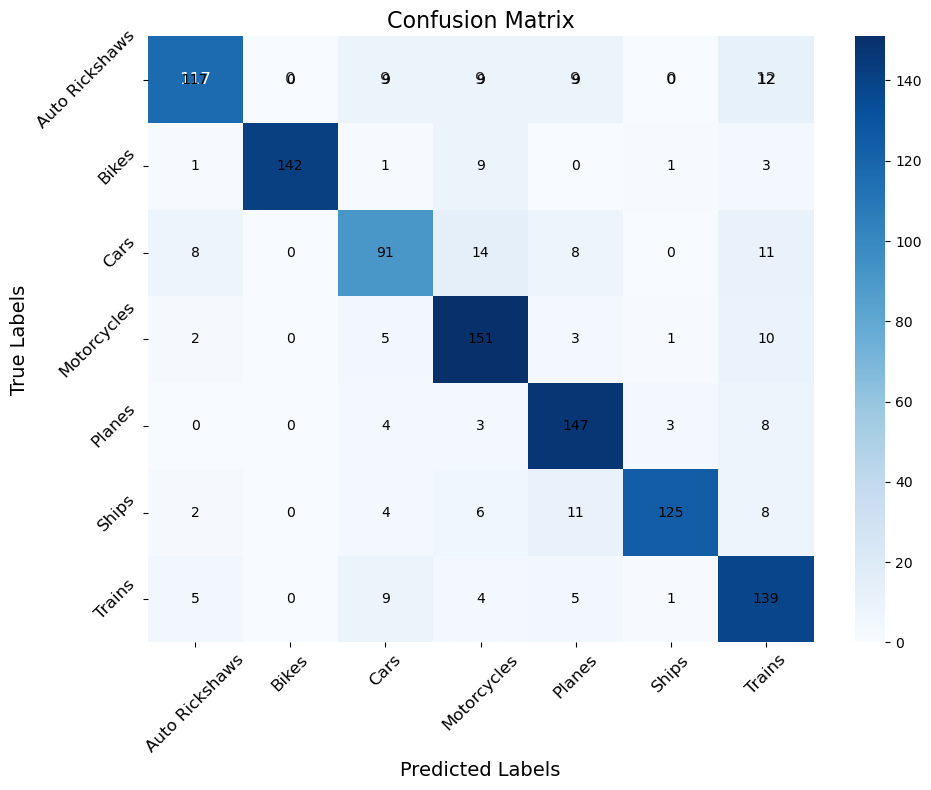

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(Y_test, predicted_classes)

# Plot the confusion matrix with all blocks numbered
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 12})
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel("True Labels", fontsize=14)
plt.xlabel("Predicted Labels", fontsize=14)

# Ensure every block is annotated, including zeros
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, conf_matrix[i, j],
                 ha='center', va='center', color='black', fontsize=10)

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Binarize the labels for multi-class ROC
y_test_binarized = to_categorical(Y_test, num_classes=len(le.classes_))

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

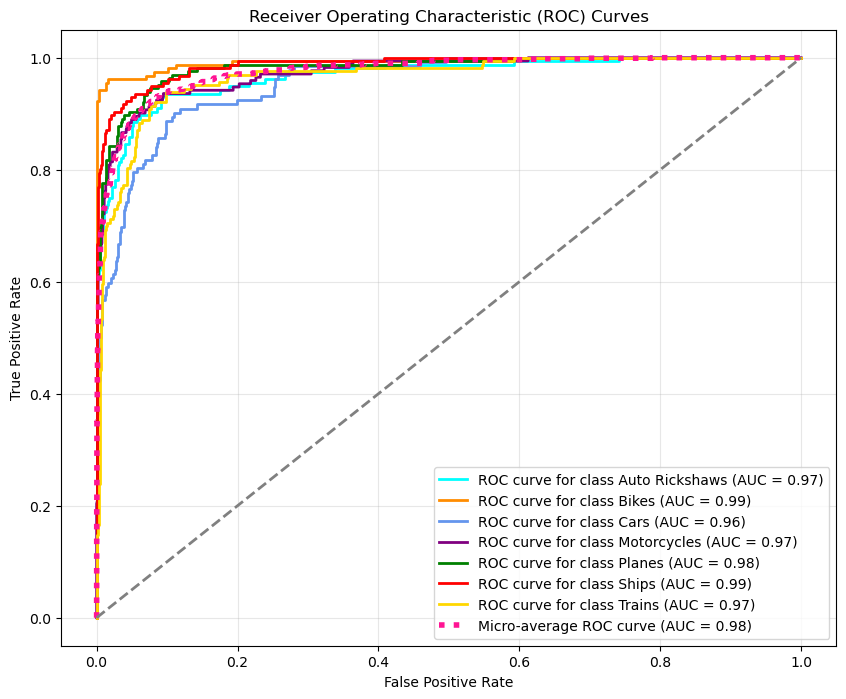

In [ ]:
# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'purple', 'green', 'red', 'gold'])

for i, color in zip(range(len(le.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve for class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.2f})")

# Plot diagonal line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
